In [1]:
# import os

# os.chdir("c:\\Users\\pasqu\\Github\\m2ds_altegrad\\Lab4_GraphMining\\code")

In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# 2 Analysing a Real-World Graph
## 2.1 Load Graph and Simple Statistics

Task 1

In [3]:
G = nx.read_edgelist("datasets/CA-HepTh.txt", comments="#", delimiter="\t")

print("The CA-HepTh graph has ", G.number_of_nodes(), " nodes.")
print("The CA-HepTh graph has ", G.number_of_edges(), " edges.")

The CA-HepTh graph has  9877  nodes.
The CA-HepTh graph has  25998  edges.


## 2.2 Connected Components

Task 2

In [4]:
print(
    "The CA-HepTh graph has ",
    nx.number_connected_components(G),
    " connected components.",
)

largest_cc = max(nx.connected_components(G), key=len)

subG = G.subgraph(largest_cc)
print(
    "The largest connected components in CA-HepTh has ",
    subG.number_of_edges(),
    " edges.",
)

The CA-HepTh graph has  429  connected components.
The largest connected components in CA-HepTh has  24827  edges.


## 2.3 Analysis of the Degree Distribution of the Graph

Task 3

In [5]:
degree_sequence = [G.degree(node) for node in G.nodes()]
print("The minimum degree of the nodes in CA-HepTh is", np.min(degree_sequence))
print("The maximum degree of the nodes in CA-HepTh is", np.max(degree_sequence))
print("The median degree of the nodes in CA-HepTh is", np.median(degree_sequence))
print("The mean degree of the nodes in CA-HepTh is", np.mean(degree_sequence))

The minimum degree of the nodes in CA-HepTh is 1
The maximum degree of the nodes in CA-HepTh is 65
The median degree of the nodes in CA-HepTh is 3.0
The mean degree of the nodes in CA-HepTh is 5.264351523742027


Task 4

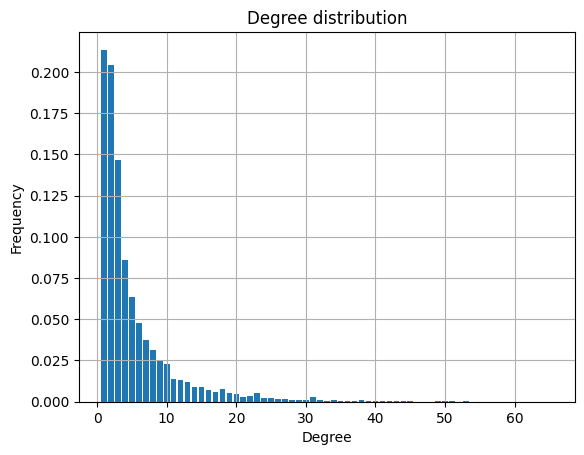

In [6]:
degree, count = np.unique(degree_sequence, return_counts=True)
freq = count / count.sum()
plt.bar(degree, freq)
plt.grid()
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.title("Degree distribution")
plt.show()

## 2.4 Clustering Coefficient

Task 5

In [7]:
print("The global clustering coefficient of the CA-HepTh graph is", nx.transitivity(G))

The global clustering coefficient of the CA-HepTh graph is 0.2839996525875546


# 3. Community Detection
## 3.1 Spectral Clustering

Task 6

In [8]:
import networkx as nx
import numpy as np
from scipy.sparse.linalg import eigs
from scipy.sparse import diags, eye
from random import randint
from sklearn.cluster import KMeans

In [9]:
def spectral_clustering(G, k):

    A = nx.adjacency_matrix(G)
    D_inv = diags([1 / G.degree(node) for node in G.nodes()])

    lrw = eye(G.number_of_nodes()) - D_inv @ A

    evals, evecs = eigs(lrw, k=k, which="SR")

    evecs = np.real(evecs)  # numerical stability

    kmeans = KMeans(n_clusters=k).fit(evecs)

    clustering = {}
    for i, node in enumerate(G.nodes()):
        clustering[node] = kmeans.labels_[i]

    return clustering

Task 7

In [10]:
clustering_of_largest_cc = spectral_clustering(subG, 50)
# print(clustering_of_largest_cc)

/tmp/ipykernel_2272/2063546433.py:3: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


## 3.2 Modularity

In [54]:
def modularity(G, clustering):
    m = G.number_of_edges()
    communities = list(set(clustering.values()))

    Q = 0
    for c in communities:
        nodes = []
        for node, cluster in clustering.items():
            if cluster == c:
                nodes.append(node)

        dc = sum([G.degree(node) for node in nodes])

        lc = G.subgraph(nodes).number_of_edges()

        Q += (lc / m) - (dc / (2 * m)) ** 2

    return Q

In [55]:
G = nx.Graph()
G.add_nodes_from([1, 2, 3, 4, 5, 6, 7, 8, 9])
G.add_edges_from(
    [
        (1, 2),
        (1, 3),
        (1, 4),
        (2, 1),
        (2, 3),
        (3, 1),
        (3, 2),
        (3, 4),
        (4, 1),
        (4, 3),
        (4, 5),
        (5, 4),
        (5, 6),
        (6, 7),
        (6, 8),
        (6, 9),
        (7, 6),
        (7, 8),
        (7, 9),
        (8, 6),
        (8, 7),
        (8, 9),
        (9, 6),
        (9, 7),
        (9, 8),
    ]
)

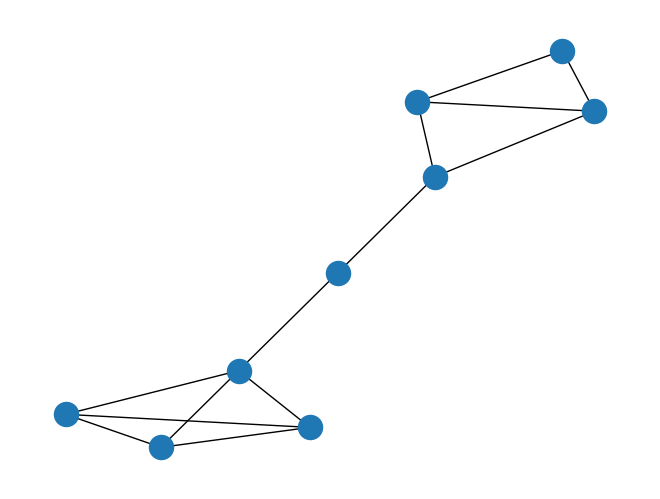

In [56]:
nx.draw(G)

In [57]:
clustering = {1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 1, 7: 1, 8: 1, 9: 1}
modularity(G, clustering)

0.42307692307692313

In [58]:
clustering = {1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0}
modularity(G, clustering)

-0.050295857988165577

# 4 Graph Classification using Graph Kernels
## 4.1 Dataset Generation

Task 10

In [11]:
import networkx as nx
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [12]:
def create_dataset():
    Gs = list()
    y = list()

    for i in range(3, 103):
        G = nx.cycle_graph(i)
        Gs.append(G)
        y.append(0)

        G = nx.path_graph(i)
        Gs.append(G)
        y.append(1)

    return Gs, y

In [13]:
Gs, y = create_dataset()
G_train, G_test, y_train, y_test = train_test_split(Gs, y, test_size=0.1)

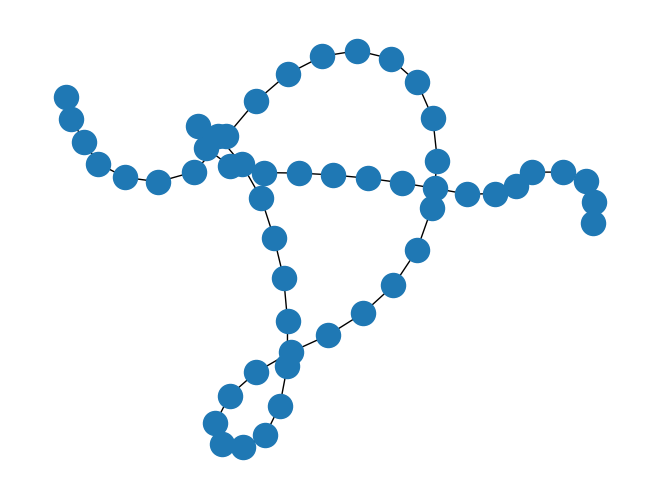

In [14]:
nx.draw(Gs[101])

In [15]:
def shortest_path_kernel(Gs_train, Gs_test):
    all_paths = dict()
    sp_counts_train = dict()

    for i, G in enumerate(Gs_train):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_train[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_train[i]:
                        sp_counts_train[i][length] += 1
                    else:
                        sp_counts_train[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    sp_counts_test = dict()

    for i, G in enumerate(Gs_test):
        sp_lengths = dict(nx.shortest_path_length(G))
        sp_counts_test[i] = dict()
        nodes = G.nodes()
        for v1 in nodes:
            for v2 in nodes:
                if v2 in sp_lengths[v1]:
                    length = sp_lengths[v1][v2]
                    if length in sp_counts_test[i]:
                        sp_counts_test[i][length] += 1
                    else:
                        sp_counts_test[i][length] = 1

                    if length not in all_paths:
                        all_paths[length] = len(all_paths)

    phi_train = np.zeros((len(Gs_train), len(all_paths)))
    for i in range(len(Gs_train)):
        for length in sp_counts_train[i]:
            phi_train[i, all_paths[length]] = sp_counts_train[i][length]

    phi_test = np.zeros((len(Gs_test), len(all_paths)))
    for i in range(len(Gs_test)):
        for length in sp_counts_test[i]:
            phi_test[i, all_paths[length]] = sp_counts_test[i][length]

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

Task 11

In [16]:
def graphlet_kernel(Gs_train, Gs_test, n_samples=200):
    graphlets = [nx.Graph(), nx.Graph(), nx.Graph(), nx.Graph()]

    graphlets[0].add_nodes_from(range(3))

    graphlets[1].add_nodes_from(range(3))
    graphlets[1].add_edge(0, 1)

    graphlets[2].add_nodes_from(range(3))
    graphlets[2].add_edge(0, 1)
    graphlets[2].add_edge(1, 2)

    graphlets[3].add_nodes_from(range(3))
    graphlets[3].add_edge(0, 1)
    graphlets[3].add_edge(1, 2)
    graphlets[3].add_edge(0, 2)

    phi_train = np.zeros((len(Gs_train), 4))

    for i, G in enumerate(Gs_train):
        nodes = list(G.nodes())
        for _ in range(n_samples):
            subset_nodes = np.random.choice(nodes, 3, replace=False)
            subG = G.subgraph(subset_nodes)
            if nx.is_isomorphic(subG, graphlets[0]):
                phi_train[i, 0] += 1
            elif nx.is_isomorphic(subG, graphlets[1]):
                phi_train[i, 1] += 1
            elif nx.is_isomorphic(subG, graphlets[2]):
                phi_train[i, 2] += 1
            else:
                phi_train[i, 3] += 1

    phi_test = np.zeros((len(Gs_test), 4))

    for i, G in enumerate(Gs_test):
        nodes = list(G.nodes())
        for _ in range(n_samples):
            subset_nodes = np.random.choice(nodes, 3, replace=False)
            subG = G.subgraph(subset_nodes)
            if nx.is_isomorphic(subG, graphlets[0]):
                phi_test[i, 0] += 1
            elif nx.is_isomorphic(subG, graphlets[1]):
                phi_test[i, 1] += 1
            elif nx.is_isomorphic(subG, graphlets[2]):
                phi_test[i, 2] += 1
            else:
                phi_test[i, 3] += 1

    K_train = np.dot(phi_train, phi_train.T)
    K_test = np.dot(phi_test, phi_train.T)

    return K_train, K_test

Task 12

In [17]:
K_train_sp, K_test_sp = shortest_path_kernel(G_train, G_test)
K_train_gr, K_test_gr = graphlet_kernel(G_train, G_test)

Task 13

In [18]:
clf = SVC(kernel="precomputed")
clf.fit(K_train_sp, y_train)
y_pred_sp = clf.predict(K_test_sp)

clf = SVC(kernel="precomputed")
clf.fit(K_train_gr, y_train)
y_pred_gr = clf.predict(K_test_gr)

print("Accuracy with shortest path kernel :", accuracy_score(y_test, y_pred_sp))
print("Accuracy with graphlet kernel :", accuracy_score(y_test, y_pred_gr))

Accuracy with shortest path kernel : 0.95
Accuracy with graphlet kernel : 0.45
